# Animal Classification

In [2]:
# TODO: Download datasets
import tensorflow as tf
print(tf.__version__)

2.16.1


In [3]:
!wget https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
!unzip animal.zip -d temp

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-30 12:58:19--  https://storage.googleapis.com/adsa-data/animal-classification/animal.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 74.125.141.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570445498 (544M) [application/zip]
Saving to: 'animal.zip'

animal.zip          100%[===================>] 544.02M  37.2MB/s    in 16s     

2024-11-30 12:58:35 (34.4 MB/s) - 'animal.zip' saved [570445498/570445498]

Archive:  animal.zip
   creating: temp/train/
  inflating: temp/train/cat.0.jpg    
  inflating: temp/train/cat.1.jpg    
  inflating: temp/train/cat.10.jpg   
  inflating: temp/train/cat.100.jpg  
  inflating: temp/train/cat.1000.jpg  
  inflating: temp/train/cat.10000.jpg  
  inflating: temp/train/cat.10001.jpg  
  inflating: temp/train/cat.10002.jpg  
  inflating: temp/train/cat.10003.jpg  
  inflating: temp/tr

In [4]:
!mkdir -p data/dog
!mkdir -p data/cat
!cp temp/train/dog.* data/dog/
!cp temp/train/cat.* data/cat/

In [5]:
import os

dog_count = len(os.listdir("./data/dog"))
cat_count = len(os.listdir("./data/cat"))
print("Dog pictures: ", dog_count)
print("Cat pictures: ", cat_count)

Dog pictures:  12500
Cat pictures:  12500


## Data Preparation

In [6]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=32

In [7]:
# TODO: Split and load datasets
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/data',
    labels='inferred',  # Automatically infer labels based on folder names
    label_mode='int',   # Output labels as integers
    class_names=None,   # Use folder names to create class labels
    color_mode='rgb',   # Load images in RGB format
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Reserve 20% of data for validation
    subset='training',     # This is the training subset
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/data',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Same split ratio as in train_ds
    subset='validation',   # This is the validation subset
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


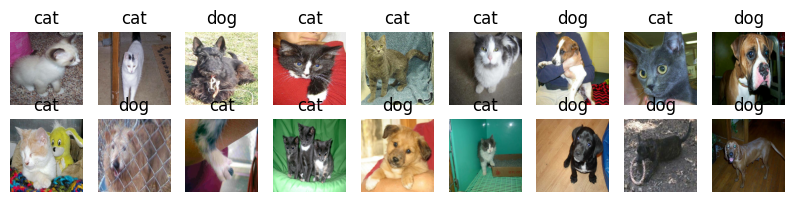

In [10]:
# TODO: Plot some images along with their labels
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(9, 9, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
# TODO: Set cache for datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Preparation

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

model = tf.keras.models.Sequential()

# TODO: Load EfficientNetB7 model with pretrained weights
# but without the fully-connected layer at the top.
# We want to add our own FC layers and outputs
base = tf.keras.applications.EfficientNetB7(
    weights = 'imagenet',
    include_top = False,
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
)
model.add(base)

# TODO: Add a GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D())

# TODO: Add a Dropout layer
model.add(Dropout(0.5))

# TODO: Add outputs
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# Allow model's weights to be updated
model.trainable = True

# TODO: Freeze base layers (Don't allow weights of the base to be updated)
for layer in base.layers:
    layer.trainable = False

for layer in model.layers:
    print(layer.name, ' ', layer.trainable)

# TODO: Add the loss function based on your outputs
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
efficientnetb7   True
global_average_pooling2d   True
dropout   True
dense   True
dense_1   True


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

## Training

In [13]:
# Train the model for 1 epoch
history = model.fit(
    train_ds,               # The training dataset
    epochs=1,               # Train for 1 epoch
    validation_data=val_ds, # The validation dataset
    verbose=1               # Display progress during training
)

# Optionally, print the final training and validation accuracy/loss
print("Training complete. Final results:")
print("Training Loss: ", history.history['loss'][-1])
print("Training Accuracy: ", history.history['accuracy'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

I0000 00:00:1732971576.284606     116 service.cc:145] XLA service 0x7a09940f0be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732971576.284674     116 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732971576.284680     116 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732971670.173767     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 250s 200ms/step - accuracy: 0.9490 - loss: 0.1270 - val_accuracy: 0.9730 - val_loss: 0.0660
Training complete. Final results:
Training Loss:  0.10500209778547287
Training Accuracy:  0.9597499966621399
Validation Loss:  0.06602072715759277
Validation Accuracy:  0.9729999899864197


## Testing

In [14]:
# TODO: Load test set
!wget https://drive.google.com/uc?id=1AD_I129zEshKO_LgLkDjOyLUbc51L6GB/content/animal-test.zip
!unzip animal.zip -d temp_test

--2024-11-30 13:03:16--  https://drive.google.com/uc?id=1AD_I129zEshKO_LgLkDjOyLUbc51L6GB/content/animal-test.zip
Resolving drive.google.com (drive.google.com)... 74.125.26.102, 74.125.26.101, 74.125.26.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.102|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-11-30 13:03:16 ERROR 404: Not Found.

Archive:  animal.zip
   creating: temp_test/train/
  inflating: temp_test/train/cat.0.jpg  
  inflating: temp_test/train/cat.1.jpg  
  inflating: temp_test/train/cat.10.jpg  
  inflating: temp_test/train/cat.100.jpg  
  inflating: temp_test/train/cat.1000.jpg  
  inflating: temp_test/train/cat.10000.jpg  
  inflating: temp_test/train/cat.10001.jpg  
  inflating: temp_test/train/cat.10002.jpg  
  inflating: temp_test/train/cat.10003.jpg  
  inflating: temp_test/train/cat.10004.jpg  
  inflating: temp_test/train/cat.10005.jpg  
  inflating: temp_test/train/cat.10006.jpg  
  inflating: temp_test/train/ca

In [16]:
# TODO: Retry again with downloaded images


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/working/temp_test/train/',
    labels='inferred',   # Automatically infer labels based on folder names
    label_mode='int',    # Output labels as integers
    batch_size=batch_size,       # Use the same batch size as during training
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT), # Use the same image size as used during training
    shuffle=False,       # No shuffling for final test evaluation
    seed=42,
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

# Print the results
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

Found 0 files belonging to 0 classes.


ValueError: No images found in directory /kaggle/working/temp_test/train/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')